# Vehicle Insurance risk prediction

## 1) Introduction 

Port Seguro is one of the largest vehicle insurance companies in Brazil. In this notebook we are trying to predict the probability that a driver will raise an insurance claim. Accurately predicting the probability will reduce the risk and can lead to reduction in cost of insurance. Given below are sevaral anonymized features out of which some are related to the type of vehicle used and some related to the driver. Based on this we need to predict the probability of claim.

## 2) Importing libraries and loading the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
#from imblearn.under_sampling import RandomUnderSampler,RepeatedEditedNearestNeighbours
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV

Here we are loading the data which is in csv format and storing it as a pandas Dataframe. %time is a magic command which gives the time taken to execute the command

In [2]:
%time df_raw = pd.read_csv('train.csv')
%time df_test = pd.read_csv('test.csv')

Wall time: 4.09 s
Wall time: 5.98 s


## 3) Exploring the data

Once we load the dataset, we first need to explore it to know how many features and what kind of features are present.

In [3]:
df_raw.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7000,0.2000,0.7181,10,1,-1,0,1,4,1,0,0,1,12,2,0.4000,0.8837,0.3708,3.6056,0.6000,0.5000,0.2000,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8000,0.4000,0.7661,11,1,-1,0,-1,11,1,1,2,1,19,3,0.3162,0.6188,0.3887,2.4495,0.3000,0.1000,0.3000,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0000,0.0000,-1.0000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.3162,0.6416,0.3473,3.3166,0.5000,0.7000,0.1000,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9000,0.2000,0.5809,7,1,0,0,1,11,1,1,3,1,104,1,0.3742,0.5429,0.2950,2.0000,0.6000,0.9000,0.1000,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7000,0.6000,0.8408,11,1,-1,0,-1,14,1,1,2,1,82,3,0.3161,0.5658,0.3651,2.0000,0.4000,0.6000,0.0000,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Each row represents a unique driver represented by a unique id.The features whose name which ends with 'bin' and 'cat' are binary and categorical variables. The rest of them are numerical varibles. The **target** features gives the ground truth whether a claim has been raised by driver in the previous year. If claim has been raised, then it is 1 or else 0. 

First we check whether the dataset has any missing values. But from the result we can infer that there are no missing values. Then we are trying to find out the datatypes in each of the column. Sometimes even integers may be even stored in string format.

In [4]:
df_raw.isnull().sum().sum()
#No missing values

0

In [5]:
df_raw.info()
#All columns in numerical formats.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [6]:
sample_size = df_raw.shape[0]
test_size = df_test.shape[0]

Now we explore the values in different columns using the describe method

In [7]:
df_describe_raw = df_raw.describe().T
df_describe_raw

,count,mean,std,min,25%,50%,75%,max
id,595212.0000,743803.5584,429367.8204,7.0000,371991.5000,743547.5000,1115548.7500,1488027.0000
target,595212.0000,0.0364,0.1874,0.0000,0.0000,0.0000,0.0000,1.0000
ps_ind_01,595212.0000,1.9004,1.9838,0.0000,0.0000,1.0000,3.0000,7.0000
ps_ind_02_cat,595212.0000,1.3589,0.6646,-1.0000,1.0000,1.0000,2.0000,4.0000
ps_ind_03,595212.0000,4.4233,2.6999,0.0000,2.0000,4.0000,6.0000,11.0000
ps_ind_04_cat,595212.0000,0.4168,0.4933,-1.0000,0.0000,0.0000,1.0000,1.0000
ps_ind_05_cat,595212.0000,0.4052,1.3506,-1.0000,0.0000,0.0000,0.0000,6.0000
ps_ind_06_bin,595212.0000,0.3937,0.4886,0.0000,0.0000,0.0000,1.0000,1.0000
ps_ind_07_bin,595212.0000,0.2570,0.4370,0.0000,0.0000,0.0000,1.0000,1.0000
ps_ind_08_bin,595212.0000,0.1639,0.3702,0.0000,0.0000,0.0000,0.0000,1.0000


Here if we observe the minimum column, it throws some interesting observations. There are several columns which have -1 as minimum value. But no real physical quantity linked with vehicles  take the value of -1. So, -1 may have been used as proxy for missing values . In the following steps we are going to extract the columns with the missing values and figure out the proportion of the missing values

In [8]:
missing_raw_cols = list(df_describe_raw[df_describe_raw['min'] == -1].index)
#Extracting the indices of those columns which have -1 values and converting those indices into a list
missing_raw_cols

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_05_cat',
 'ps_car_07_cat',
 'ps_car_09_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_14']

In [9]:
na_proportion_raw = []
#A list which stores the proportion of the missing values in each of the columns in missing_raw_cols list
for col in missing_raw_cols:
    na_percent = (((df_raw[col] == -1).value_counts())[True]/sample_size)*100
    #For a given column, extracting the number of entries which take value of -1 and 
    #then dividing by sample size to convert it into a proportion
    na_proportion_raw.append(na_percent)
missing_values = pd.Series(data=na_proportion_raw,index=missing_raw_cols)
#Creating a pandas series whose indices are column names and values are the proportion of missing values 
missing_values.sort_values(ascending=False)
#There are some columns where the proportion of missing values is huge

ps_car_03_cat   69.0898
ps_car_05_cat   44.7825
ps_reg_03       18.1065
ps_car_14        7.1605
ps_car_07_cat    1.9302
ps_ind_05_cat    0.9760
ps_car_09_cat    0.0956
ps_ind_02_cat    0.0363
ps_car_01_cat    0.0180
ps_ind_04_cat    0.0139
ps_car_11        0.0008
ps_car_02_cat    0.0008
ps_car_12        0.0002
dtype: float64

Repating the same process with the test set columns

In [10]:
df_test_describe = df_test.describe().T
missing_test_cols = list(df_test_describe[df_test_describe['min'] == -1].index)
na_proportion_test = []
for col in missing_test_cols:
    na_percent = (((df_test[col] == -1).value_counts())[True]/test_size)*100
    na_proportion_test.append(na_percent)
missing_values_test = pd.Series(data=na_proportion_test,index=missing_test_cols)
missing_values_test.sort_values(ascending=False)


ps_car_03_cat   69.0972
ps_car_05_cat   44.8423
ps_reg_03       18.1094
ps_car_14        7.1465
ps_car_07_cat    1.9412
ps_ind_05_cat    0.9756
ps_car_09_cat    0.0982
ps_ind_02_cat    0.0344
ps_car_01_cat    0.0179
ps_ind_04_cat    0.0162
ps_car_02_cat    0.0006
ps_car_11        0.0001
dtype: float64

## 4) Cleaning the data

If we observe the column ps_car_12 has -1 values only in training set and not in the test set and more over the proportion is also less. So, we drop those rows in the training set which has -1 in this particular row

In [11]:
drop_rows = np.flatnonzero(df_raw.ps_car_12 == -1)#298018
df_raw = df_raw.drop(labels=drop_rows,axis=0)

A missing value can mean two things, either the value is not known(i.e the value exists but the customer might not have disclosed it. Ex: Age of customer) or the value doesnt even exist(Ex:Rating for condition of previous vehicle for a person who is buying the car for the first time). So, if it is a a categorical variable, then we can leave the -1 value as it is. Since we convert that into a One hot column, then the binary column corresponding to the -1 value may be useful in classifcation. \
     For a numerical column, -1 value doesn't make sense. So we are going  to impute those values. Now, if value of 0 is not used in the numerical column then we can use the value 0 for missing value. But if 0 is used then we can replace the missing value with the median

In [12]:
for col in ['ps_reg_03','ps_car_14','ps_car_11']:
    print (col + ' '+ str(sample_size -1 - (df_raw[col]==0).value_counts()[False]))
    #Checking the no of rows with value 0 in the given columns

ps_reg_03 0
ps_car_14 0
ps_car_11 25983


In [13]:
fill_dict = {'ps_reg_03':{-1:0},'ps_car_14':{-1:0},'ps_car_11':{-1:df_raw['ps_car_11'].median()}}
df_raw.replace(to_replace = fill_dict,inplace = True)
df_test.replace(to_replace = fill_dict,inplace = True)
#Replacing the -1 values in the first two features with 0 and in the 3rd feature replacing -1 value with median value

## 5) Visualizing the dataset

We are visualizing the distribution of the target variable in the dataset.From the above information, we can infer that this is a highly imbalanced dataset. where the majority class size is roughly 26 times that of minority class size.

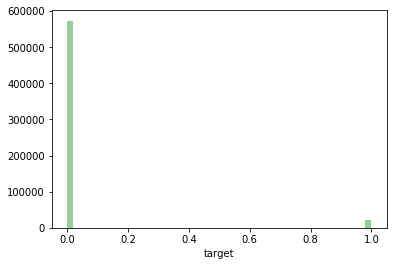

In [14]:
sns.distplot(df_raw.target,kde = False,color='green');

In [15]:
print(df_raw.target.value_counts()[0]/df_raw.target.value_counts()[1])

26.43666451553425


In [16]:
target_mean = df_raw.target.mean()#Storing the mean of the target column or  the proortion of minority labels
target_mean

0.03644757909380035

Now we are going to visualize the distribution and the relation between each feature and target column. So, we are dividing features into binary , categorical and numerical columnns and visualizing for each column separately. for each column the left graph gives the distribution and the right graph gives the relation between feature and target variable. The horizontal dashed line represents the mean value.

In [17]:
binary_cols = ['ps_ind_06_bin', 'ps_ind_07_bin','ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin','ps_ind_11_bin',
               'ps_ind_12_bin', 'ps_ind_13_bin','ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin','ps_calc_15_bin',
               'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin','ps_calc_19_bin', 'ps_calc_20_bin',]

category_cols = [ 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat','ps_car_03_cat',
                 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat','ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
                 'ps_car_10_cat',]

numeric_cols = ['ps_ind_01','ps_ind_03','ps_ind_14', 'ps_ind_15', 'ps_reg_01','ps_reg_02','ps_car_11', 'ps_car_15', 
                'ps_calc_01', 'ps_calc_02','ps_calc_03', 'ps_calc_04','ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
                'ps_calc_09','ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',]

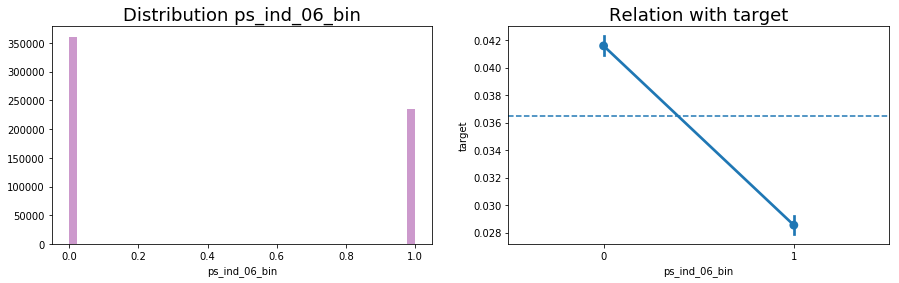

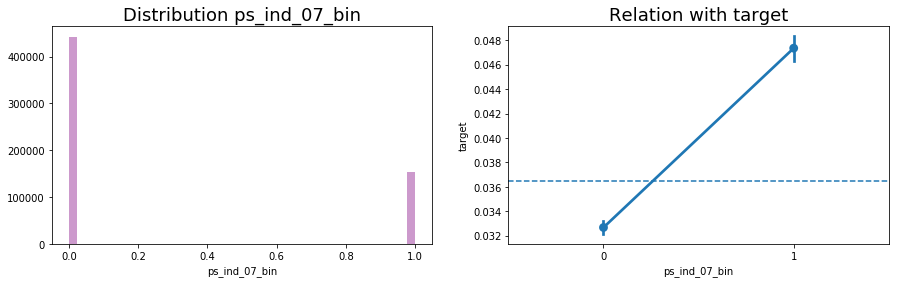

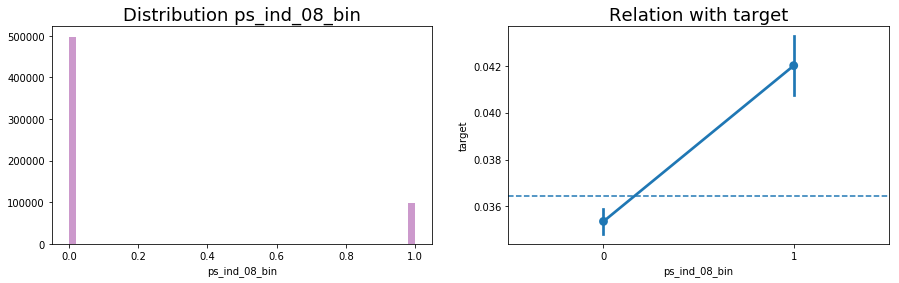

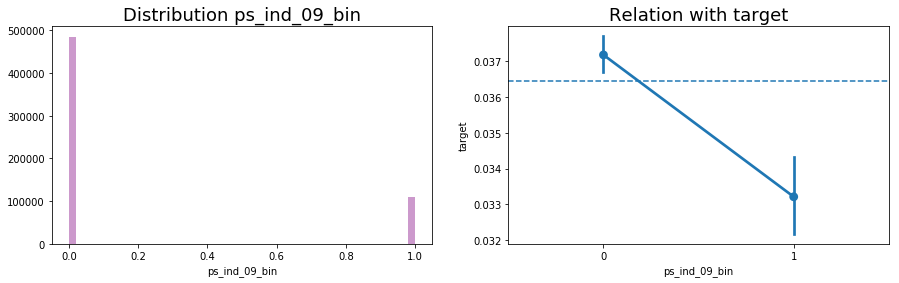

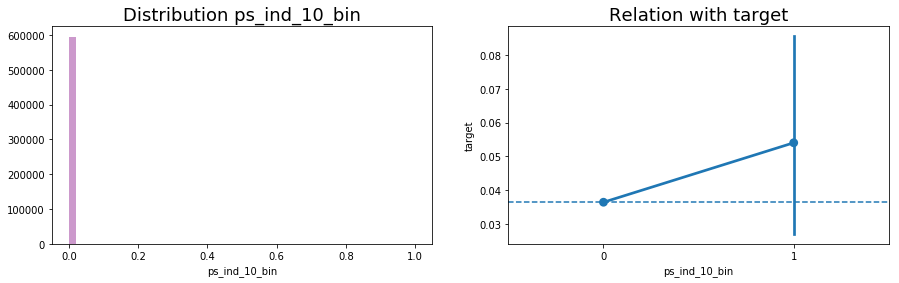

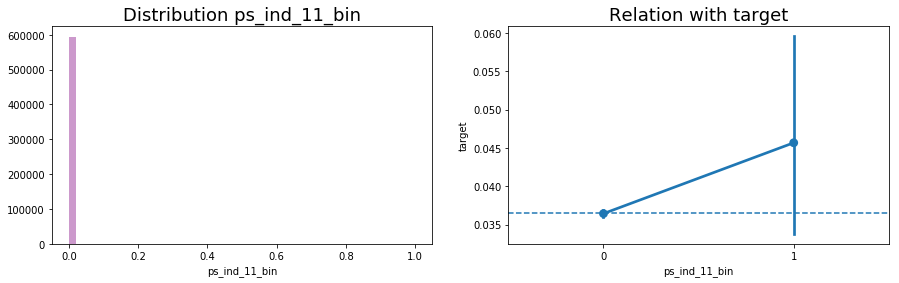

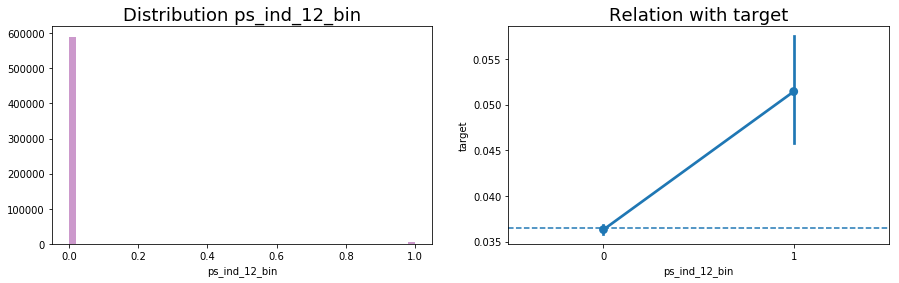

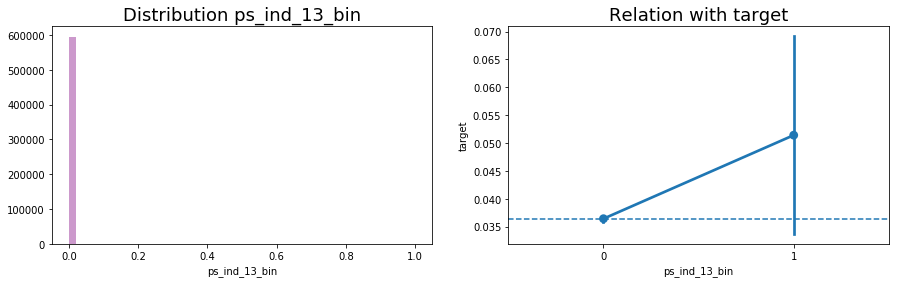

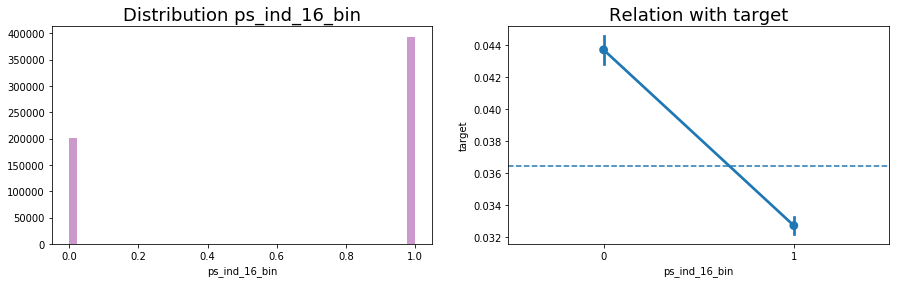

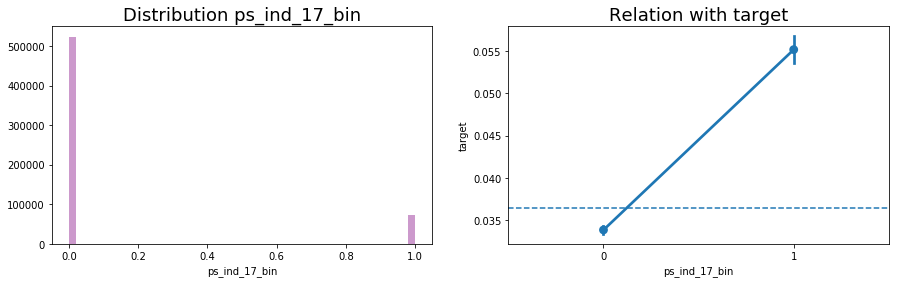

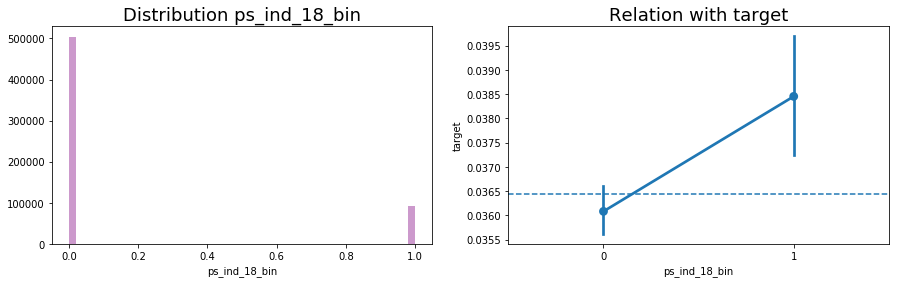

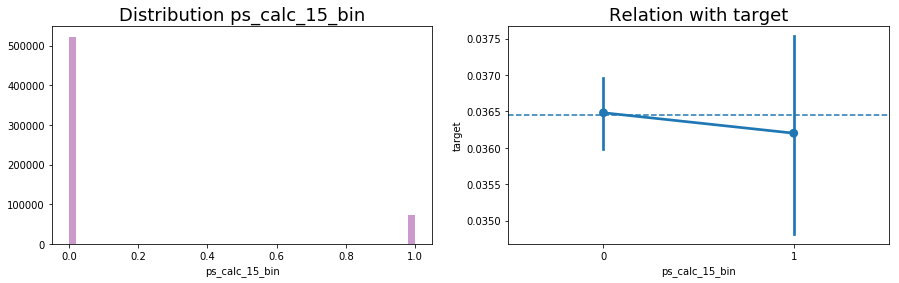

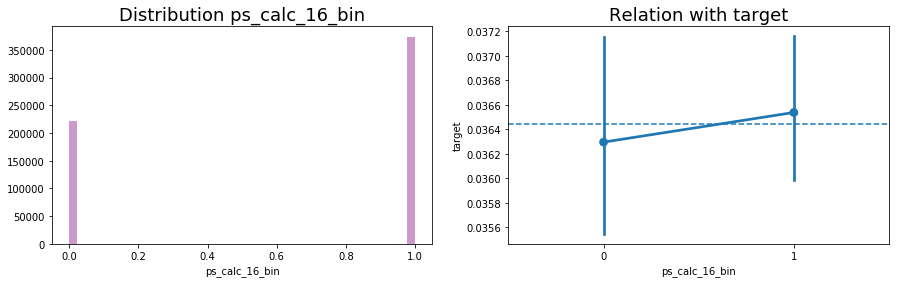

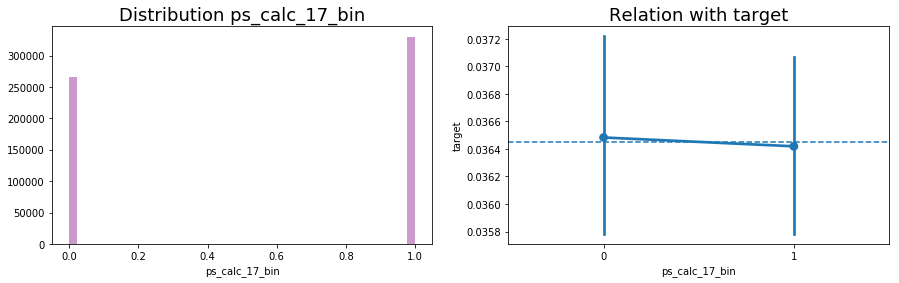

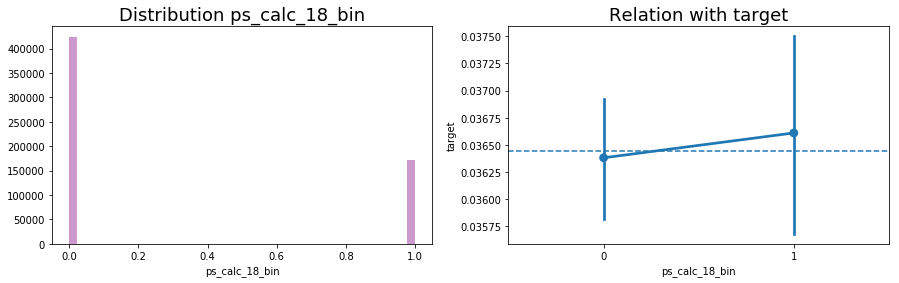

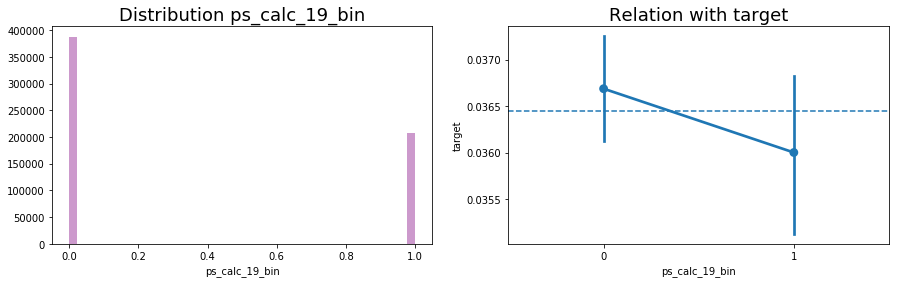

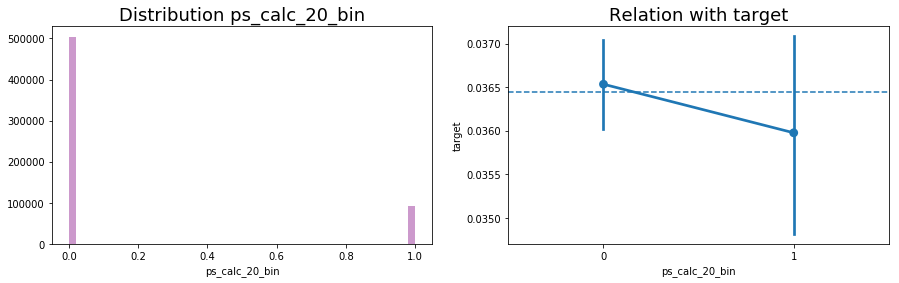

In [18]:
#Plotting binary columns
graf_cols = binary_cols

len_graf = len(graf_cols)

for i in range(len(graf_cols)):
    fig, ax = plt.subplots(ncols=2,figsize=(15,4))
    feature = graf_cols[i]
    dist_name = 'Distribution ' + feature
    ax1 = sns.distplot(df_raw[feature],kde = False,ax = ax[0],color= 'purple');
    ax1.set_title(dist_name, fontsize = 18)

    ax2 = sns.pointplot(x=feature, y="target", kind="point",data=df_raw,ax = ax[1])
    plt.axhline(y = target_mean,linestyle =  '--');
    ax2.set_title('Relation with target',  fontsize = 18)
    i += 1
    fig.show()
    
#The vertical lines are measure of variance of the estimate. 
#Long vertical bars implies that there is a chance that whatever the observed relation might have been because of chance 

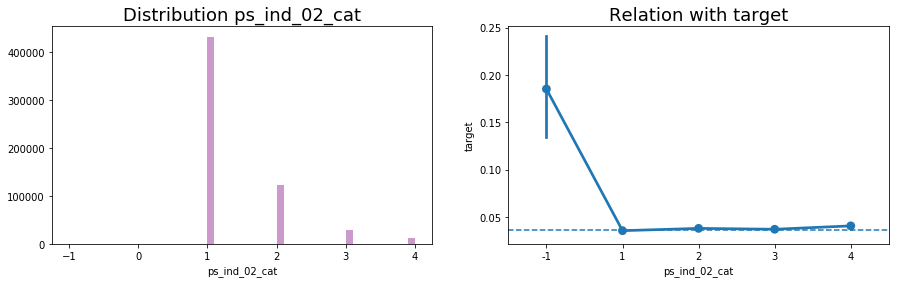

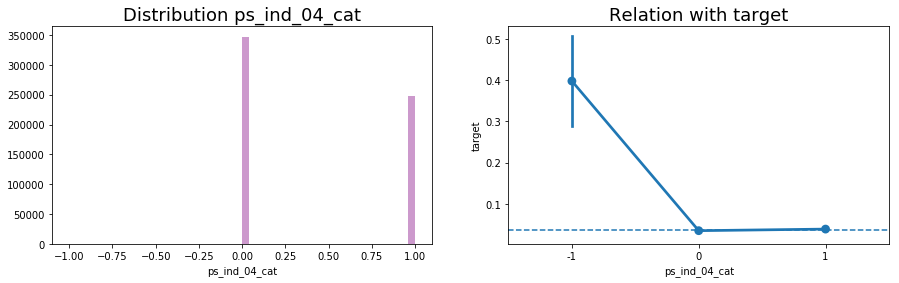

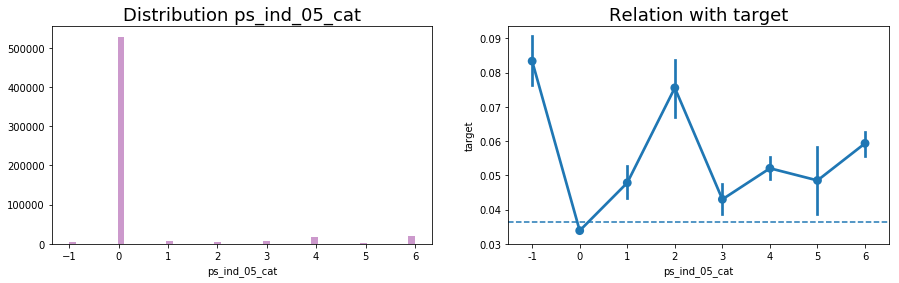

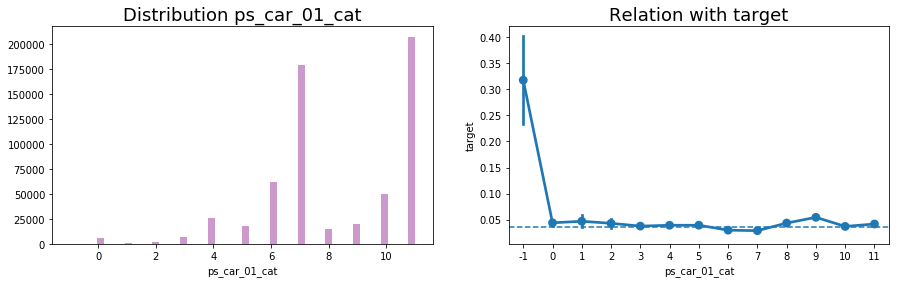

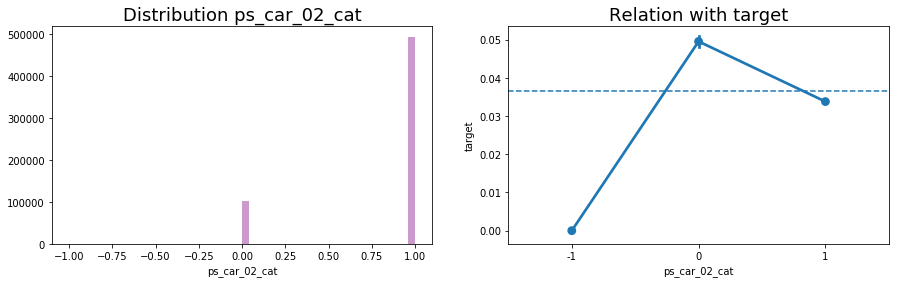

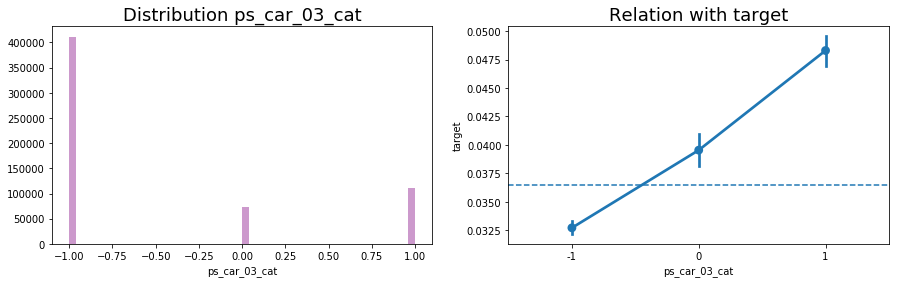

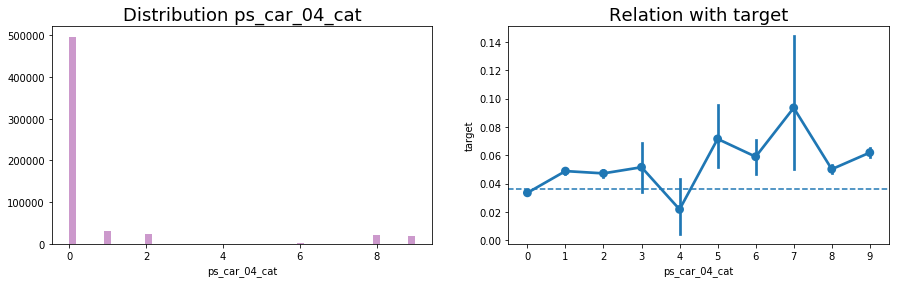

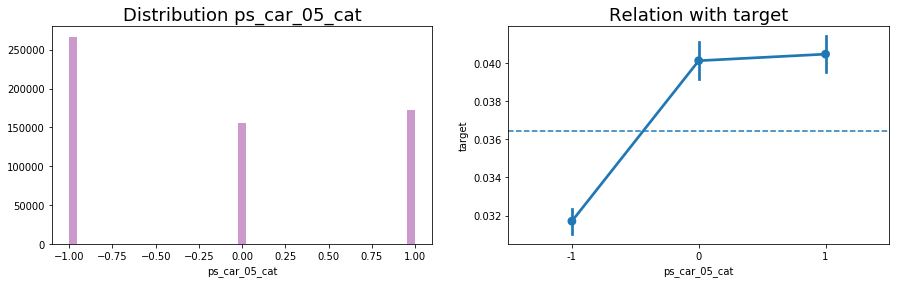

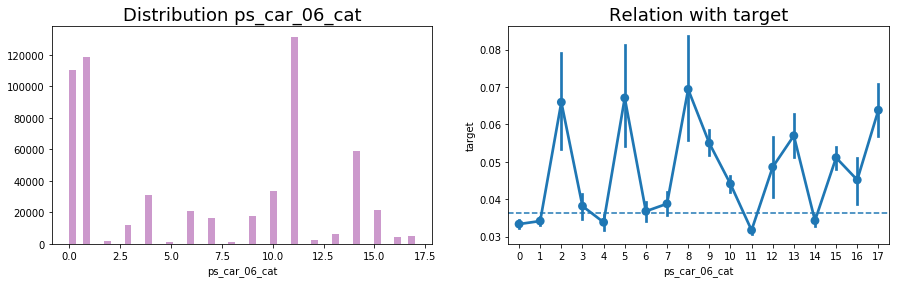

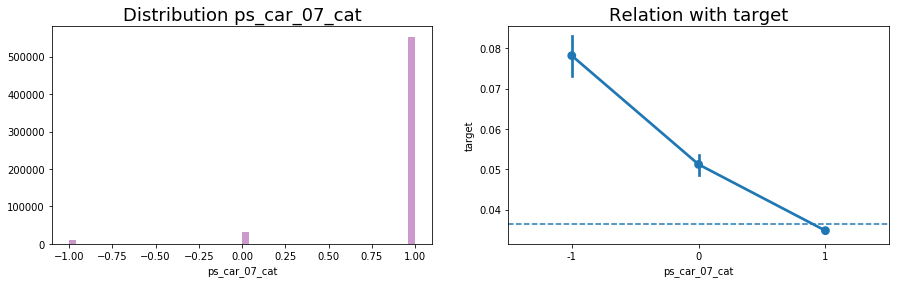

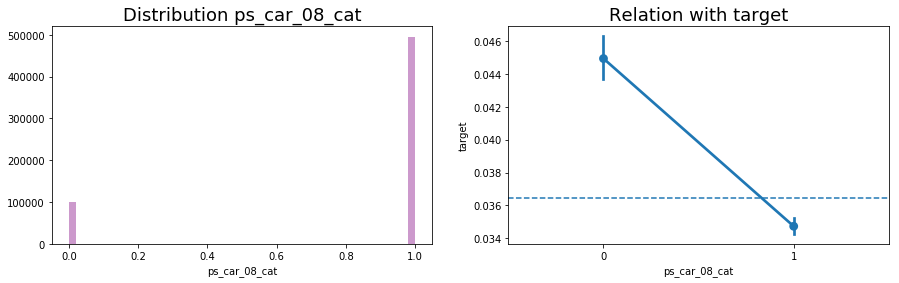

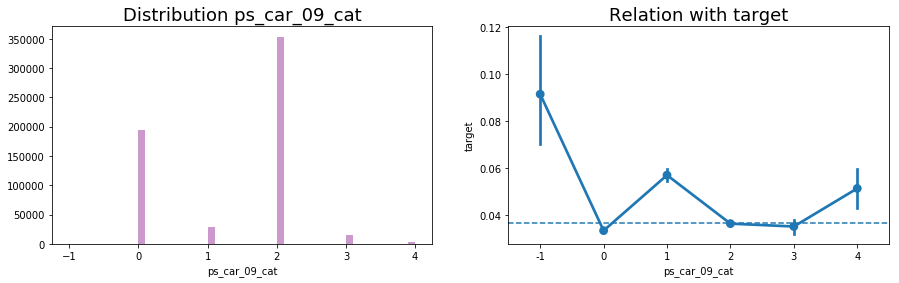

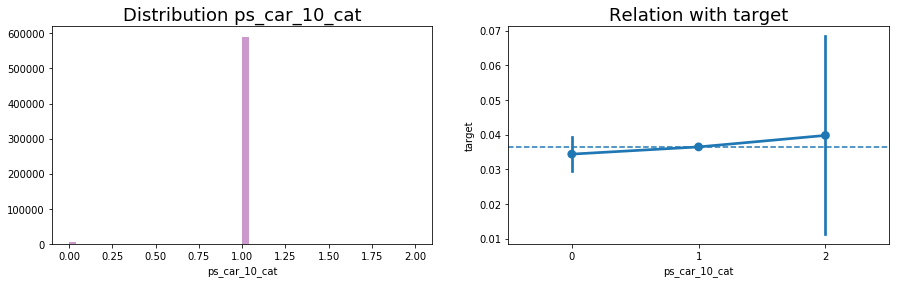

In [19]:
#Plotting categorcial columns
graf_cols =  category_cols

numeric_cols

len_graf = len(graf_cols)

for i in range(len(graf_cols)):
    fig, ax = plt.subplots(ncols=2,figsize=(15,4))
    feature = graf_cols[i]
    dist_name = 'Distribution ' + feature
    ax1 = sns.distplot(df_raw[feature],kde = False,ax = ax[0],color= 'purple');
    ax1.set_title(dist_name, fontsize = 18)

    ax2 = sns.pointplot(x=feature, y="target", kind="point",data=df_raw,ax = ax[1])
    plt.axhline(y = target_mean,linestyle =  '--');
    ax2.set_title('Relation with target',  fontsize = 18)
    i += 1
    fig.show()

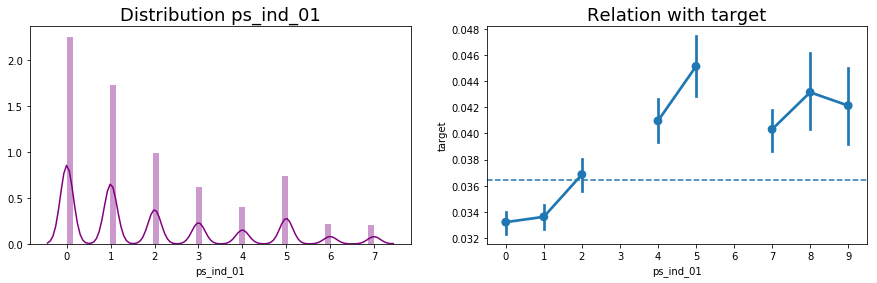

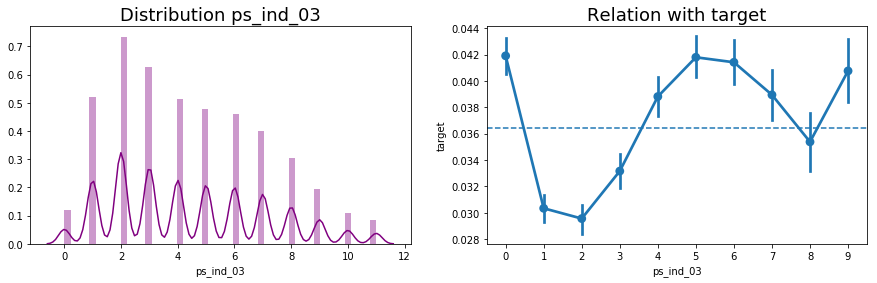

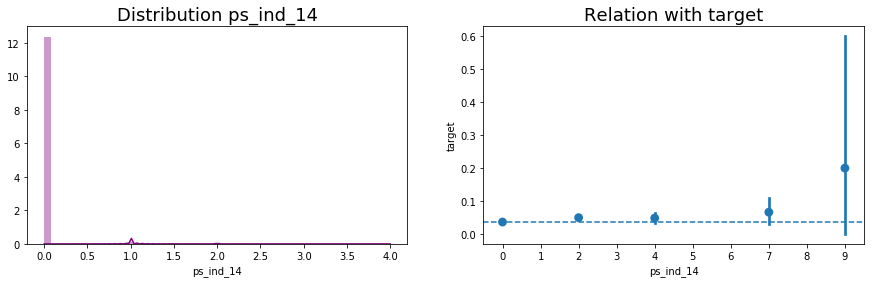

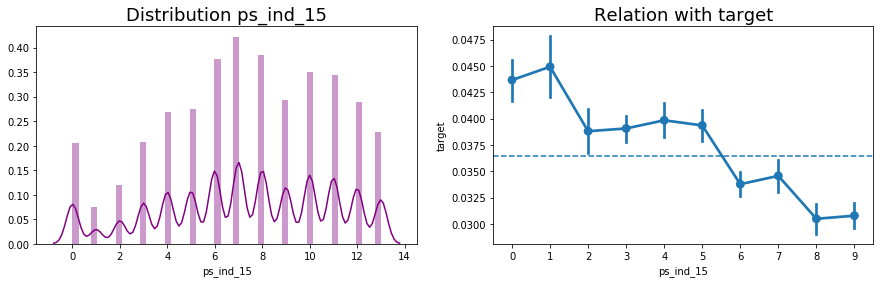

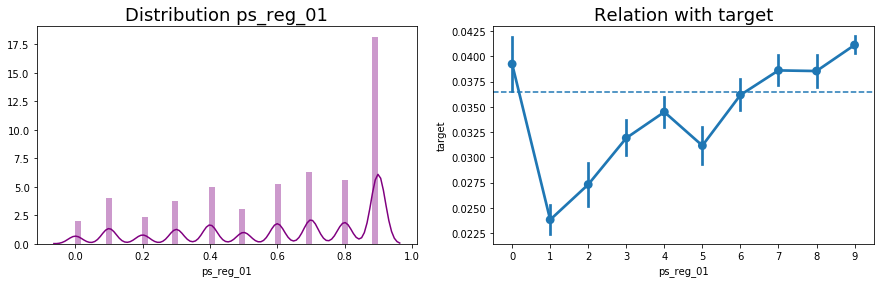

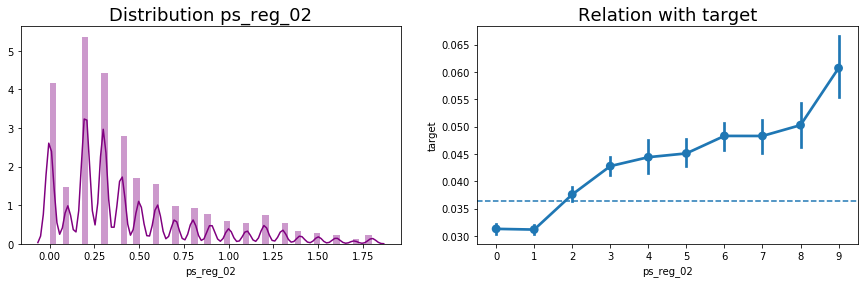

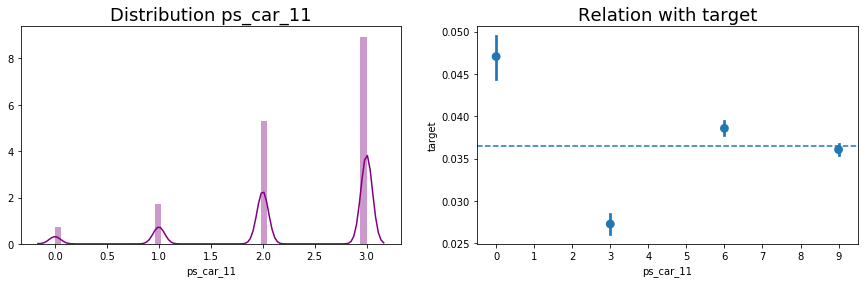

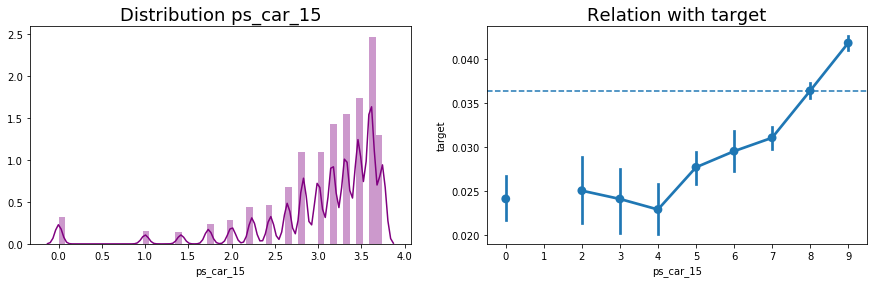

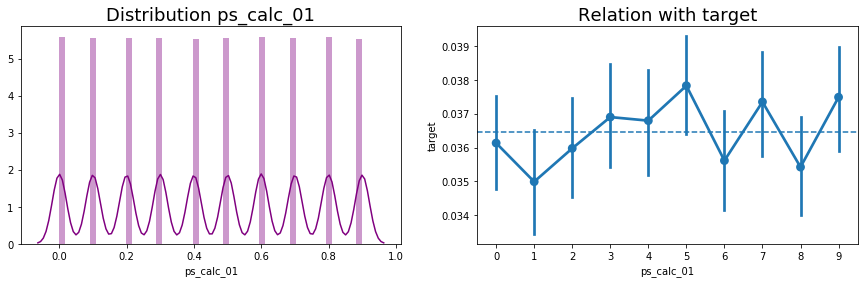

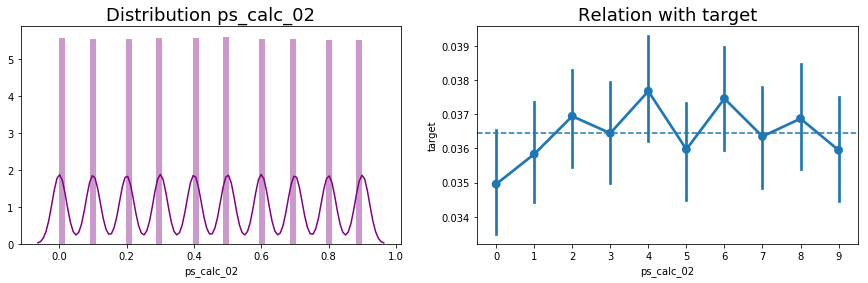

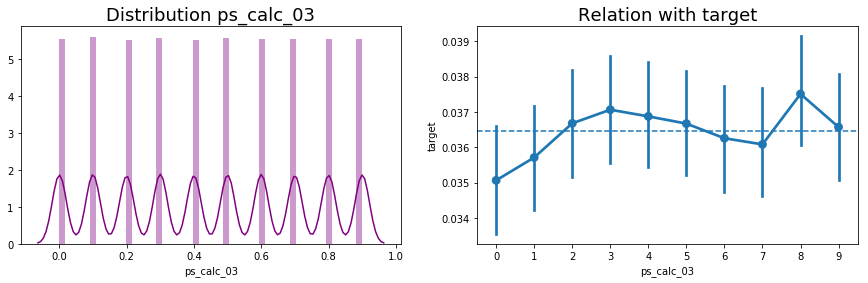

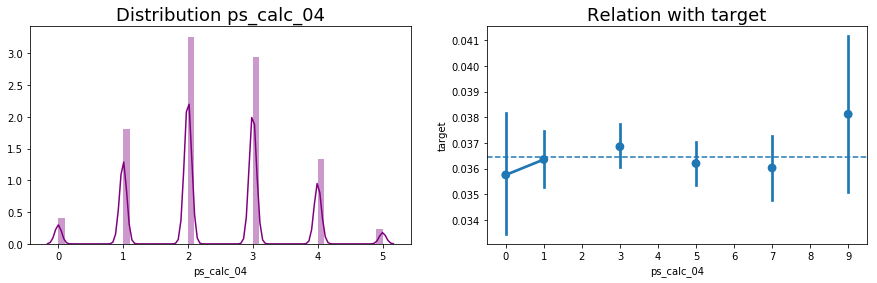

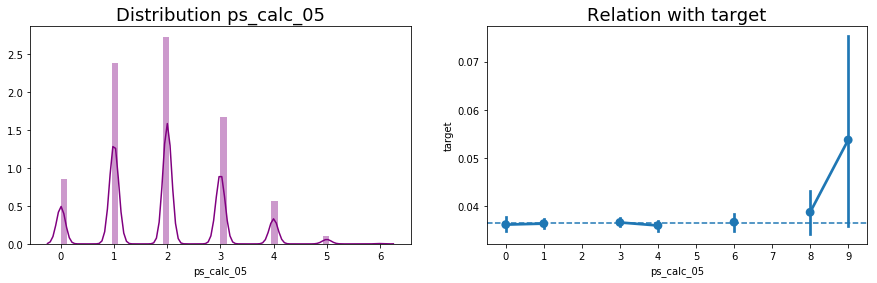

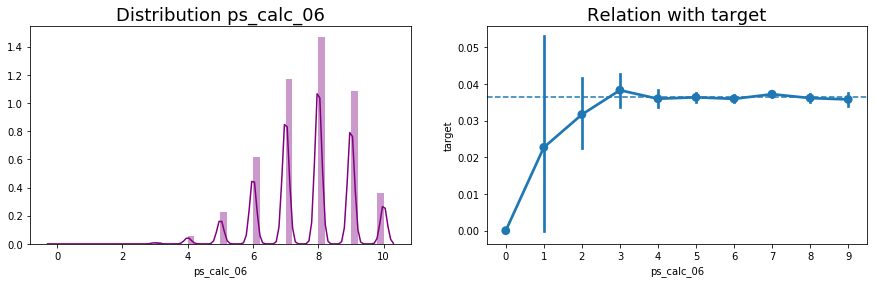

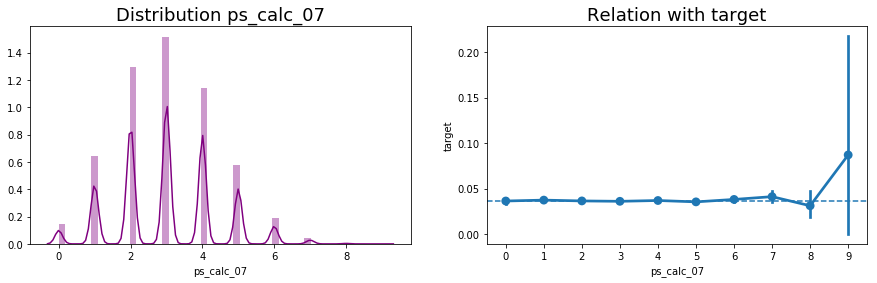

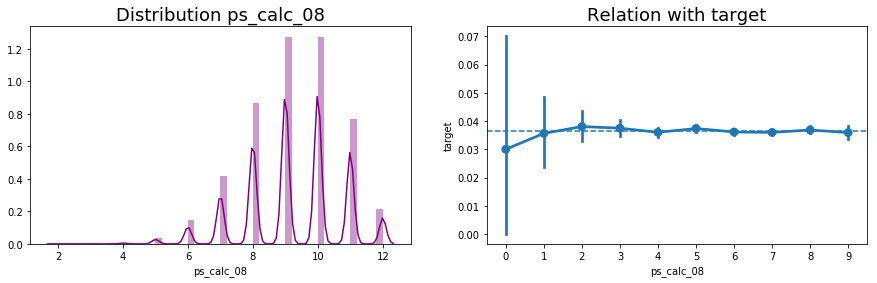

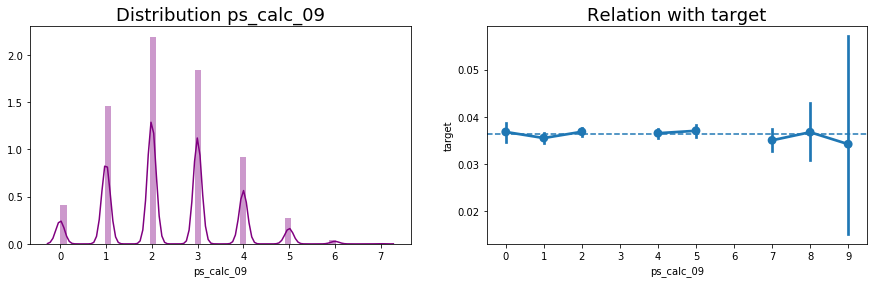

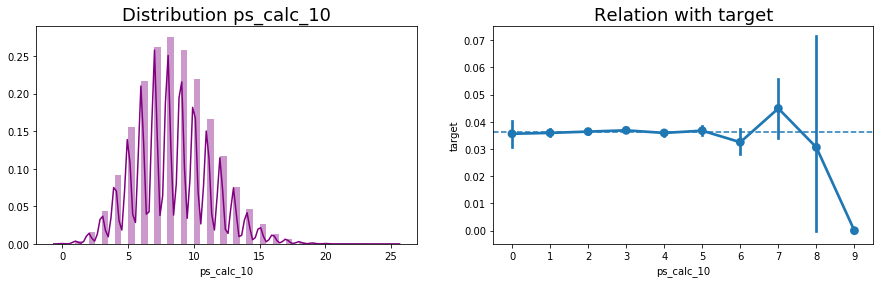

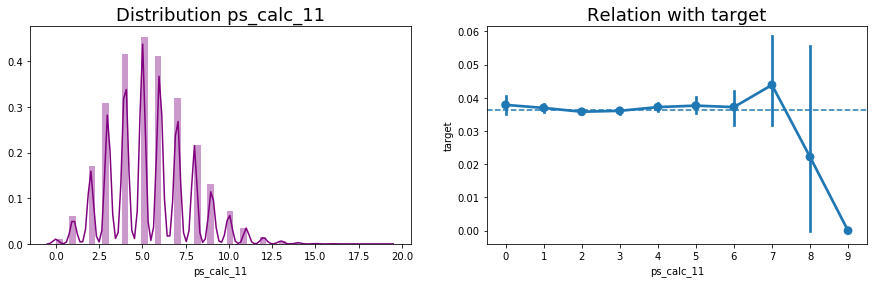

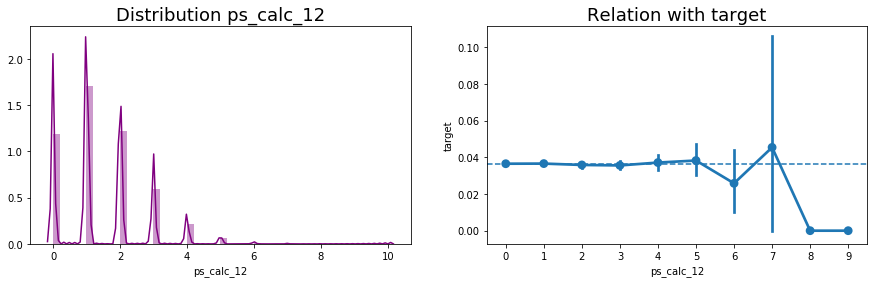

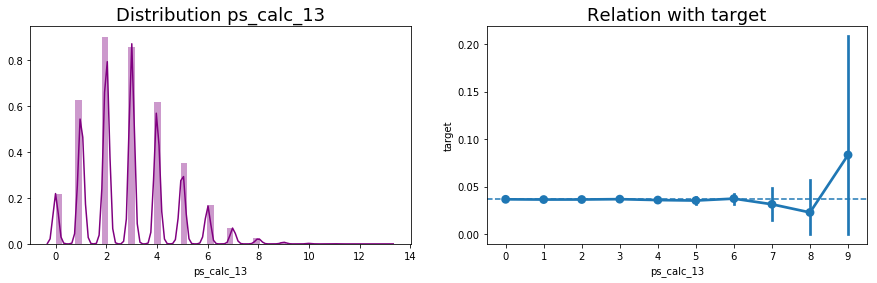

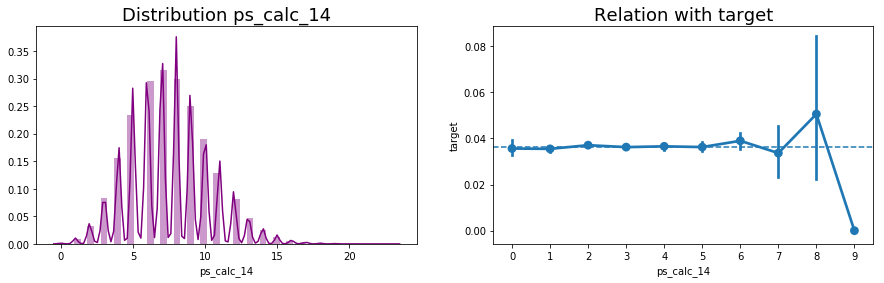

In [20]:
#Plotting numerical columns. In this for plotting the relation between feature and target, the numerical feature is converted 
#into bins.
graf_cols = numeric_cols

len_graf = len(graf_cols)

for i in range(len(graf_cols)):
    fig, ax = plt.subplots(ncols=2,figsize=(15,4))
    feature = graf_cols[i]
    dist_name = 'Distribution ' + feature
    ax1 = sns.distplot(df_raw[feature],kde = False,ax = ax[0],color= 'purple');
    ax1.set_title(dist_name, fontsize = 18)
    
    binned_feature = pd.cut(df_raw[feature], bins =10,labels = list(range(10)))
    ax2 = sns.pointplot(x=binned_feature, y="target", kind="point",data=df_raw,ax = ax[1])
    plt.axhline(y = target_mean,linestyle =  '--');
    ax2.set_title('Relation with target',  fontsize = 18)
    i += 1
    fig.show()

If we observe the distribution of the calc variables, they look perfect. So, ideally we need to further inspect them, know what they mean and how the data is collected. But since it is a anonymized dataset we cant explore further and continue as it is.

## 6) Preprocessing the dataset

Here we are first standardizing the numerical variables and then converting the categorcial variables into one hot vectors

In [21]:
std = StandardScaler()
std.fit(X = df_raw[numeric_cols])
df_raw[numeric_cols] = std.transform(df_raw[numeric_cols])
df_test[numeric_cols] = std.transform(df_test[numeric_cols])

In [22]:
df_raw_dummies = pd.get_dummies(data = df_raw[category_cols],columns=category_cols)
df_raw = pd.concat([df_raw,df_raw_dummies],axis = 1)

df_test_dummies = pd.get_dummies(data = df_test[category_cols],columns=category_cols)
df_test = pd.concat([df_test,df_test_dummies],axis = 1)

In [23]:
features = list(set(df_raw.columns)- set(category_cols)) 
df_raw = df_raw[features]
features.remove('id')
features.remove('target')
#Dropping the target and the id column

Splitting the dataset into training and validation sets. Stratify option the ensures the prooprtion of class labels remain same in both the sets

In [24]:
df_trn,df_val,label_trn,label_val = train_test_split(df_raw[features],df_raw['target'],
                                                stratify = df_raw['target'].values,test_size = 0.3,random_state = 12)

## 7) Creating the models

### 7.1) LGBM Classifier

Using LGBM classifer and tuning the parameters using Grid Search. Since it is an imbalance dataset we set the class_weight = balanced which ensures similar importance for both the labels. 

In [25]:
clf = LGBMClassifier()
params = {'num_leaves':[7,31,63,127],
         'max_depth':[3,4,5,6,-1],
         'class_weight':['balanced']}

grid_searcher = GridSearchCV(estimator = clf,param_grid=params,cv=5,verbose = 1,scoring = 'roc_auc',n_jobs = 4)

In [26]:
%time grid_searcher.fit(df_trn.values,label_trn.values)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 16.0min finished


Wall time: 16min 11s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'num_leaves': [7, 31, 63, 127], 'max_depth': [3, 4, 5, 6, -1], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [27]:
clf = grid_searcher.best_estimator_
#Selecting the best estimator

In [28]:
grid_searcher.best_params_

{'class_weight': 'balanced', 'max_depth': 3, 'num_leaves': 7}

In [29]:
%time clf.fit(df_trn,label_trn)
#Fitting the best estimator

Wall time: 8.74 s


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=3, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=7,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [30]:
feat_imp = pd.Series(data = clf.feature_importances_ , index=features)
feat_imp.sort_values(ascending=False)
#Storing the feature importances as a series

ps_ind_03           68
ps_car_13           45
ps_ind_15           33
ps_ind_01           32
ps_reg_01           31
ps_reg_03           26
ps_ind_05_cat_0     22
ps_ind_17_bin       17
ps_car_07_cat_1     14
ps_reg_02           14
ps_car_15           13
ps_car_01_cat_7     12
ps_car_12           12
ps_ind_16_bin       11
ps_ind_05_cat_6     11
ps_car_03_cat_-1    10
ps_ind_02_cat_1     10
ps_car_14           10
ps_car_09_cat_1      9
ps_ind_07_bin        9
ps_ind_06_bin        9
ps_car_06_cat_9      9
ps_ind_05_cat_2      8
ps_ind_09_bin        8
ps_car_04_cat_2      8
ps_car_01_cat_9      7
ps_calc_14           7
ps_car_11            7
ps_car_11_cat        7
ps_calc_06           6
                    ..
ps_ind_05_cat_-1     0
ps_ind_13_bin        0
ps_car_04_cat_3      0
ps_car_04_cat_7      0
ps_car_05_cat_1      0
ps_car_01_cat_8      0
ps_car_01_cat_2      0
ps_ind_10_bin        0
ps_car_04_cat_5      0
ps_ind_05_cat_3      0
ps_calc_09           0
ps_car_06_cat_6      0
ps_car_06_c

In [31]:
features = list(feat_imp.sort_values(ascending=False)[feat_imp.sort_values(ascending=False)!=0].index)
clf.fit(df_trn,label_trn)
#Selecting a subset of feature with non zero feature importances and then refitting the data

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=3, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=7,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

Since it is a highly imbalanced dataset, accuracy is not a good metric because just predicting 0 for all labels will give us 96% accuracy. So we use area under curve for ROC curve as a metric

In [32]:
trn_prob = clf.predict_proba(df_trn)
val_prob = clf.predict_proba(df_val)
trn_predict = clf.predict(df_trn)
val_predict = clf.predict(df_val)
trn_score = roc_auc_score(label_trn, trn_prob[:,1])
val_score = roc_auc_score(label_val, val_prob[:,1])

print(confusion_matrix(label_trn,trn_predict))
print(confusion_matrix(label_val,val_predict))
print(classification_report(label_trn, trn_predict))
print(classification_report(label_val, val_predict))
print('Train Score = ' + str(trn_score) + ', ' + 'Validation Score = ' + str(val_score))

[[254731 146730]
 [  6414   8772]]
[[109245  62811]
 [  2876   3632]]
              precision    recall  f1-score   support

           0       0.98      0.63      0.77    401461
           1       0.06      0.58      0.10     15186

   micro avg       0.63      0.63      0.63    416647
   macro avg       0.52      0.61      0.44    416647
weighted avg       0.94      0.63      0.74    416647

              precision    recall  f1-score   support

           0       0.97      0.63      0.77    172056
           1       0.05      0.56      0.10      6508

   micro avg       0.63      0.63      0.63    178564
   macro avg       0.51      0.60      0.43    178564
weighted avg       0.94      0.63      0.74    178564

Train Score = 0.6517370742090971, Validation Score = 0.6355991750331056


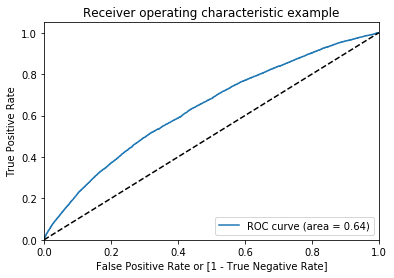

In [33]:
fpr, tpr, thresholds = roc_curve( label_val,val_prob[:,1],drop_intermediate = False )

plt.figure(figsize=(6, 4))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % val_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 7.2) Ensemble models based on undersampling 

Repeating the same steps as in the previous case

In [34]:
features = list(set(df_raw.columns) - set(category_cols)) 
features.remove('id')
features.remove('target')

In [35]:
df_trn,df_val,label_trn,label_val = train_test_split(df_raw[features],df_raw['target'],
                                                stratify = df_raw['target'].values,test_size = 0.3,random_state = 12)

Balanced Cascade: 
First we divide the input dataset into training and validation set. We create several training sets by undersampling the  training set. Each new training subset consists of all minority class examples and an equal number of unique majority class examples. This process is repeated until the number of leftover majority class examples is less than the minority class examples. 
Now, for each of this undersampled subset a classifier is fit. Each of this classifier makes prediction on validation set and the scores obtained are used as weights when creating the ensemble of classifiers. When a test set is passed, each classifier makes prediction on the test sets and the prediction of each of the test set is multiplied with the corresponding weights and the net sum will be the probability predictions for the test set.

In [36]:
def balancedcascade(df_trn,label_trn,X_test,estimator):
    #X_trn,X_val are dataframe of features and y_trn and y_val series of true labels
    
    X_trn,X_val,y_trn,y_val = train_test_split(df_trn,label_trn,
                                                stratify = label_trn.values,test_size = 0.3,random_state = 42)
    neg_index = list(y_trn[y_trn == 0].index)
    pos_index = list(y_trn[y_trn == 1].index)
    neg_count = len(neg_index)
    pos_count = len(pos_index)    
    num_classifiers = neg_count//pos_count
    weights = []
    pred_matrix = np.zeros((X_test.shape[0],num_classifiers))
    feat_imp = np.empty((X_trn.shape[1],),float)
    
    for i in range(num_classifiers):
        
        neg_indices = np.random.choice(neg_index,size = pos_count)
        all_indices = np.concatenate((neg_indices,pos_index))
        neg_index = list(set(neg_index) - set(neg_indices))
        np.random.shuffle(all_indices)
        
        trn_feature = X_trn.loc[all_indices]
        trn_label = y_trn.loc[all_indices]
        
        estimator.fit(trn_feature,trn_label)
        score = estimator.score(X_val,y_val)
        
        weights.append(score)
        pred_matrix[:,i] = estimator.predict(X_test)
        feat_imp += score*clf.feature_importances_
        
    weights = np.array(weights)
    weights_norm = weights/weights.sum()
    weighted_pred_matrix = weights_norm*pred_matrix
    test_pred_proba = np.sum(weighted_pred_matrix,axis = 1)
    return test_pred_proba

In [37]:
val_prob = balancedcascade(df_trn,label_trn,df_val,AdaBoostClassifier())

In [38]:
val_predict = np.round(val_prob).astype(int)
val_score = roc_auc_score(label_val, val_prob)

print(confusion_matrix(label_val,val_predict))
print(classification_report(label_val, val_predict))
print('Validation Score = ' + str(val_score))

[[107360  64696]
 [  2862   3646]]
              precision    recall  f1-score   support

           0       0.97      0.62      0.76    172056
           1       0.05      0.56      0.10      6508

   micro avg       0.62      0.62      0.62    178564
   macro avg       0.51      0.59      0.43    178564
weighted avg       0.94      0.62      0.74    178564

Validation Score = 0.6238880793739087


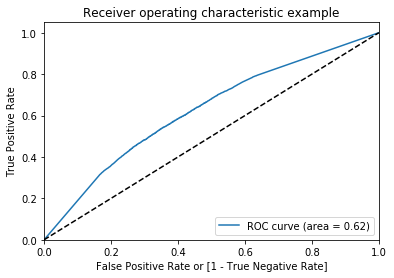

In [39]:
# Finding the optimal cutoff probability
fpr, tpr, thresholds = roc_curve( label_val,val_prob,drop_intermediate = False )

plt.figure(figsize=(6, 4))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % val_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Now in the following classifer, a small change is made. Instead of selecting unique set of majority class examples for each classifer, we use combination of some unique examples and all the majority class examples which were wrongly classifed by the previous classifier. And the weights are still calculated in the same manner. Also, the feature importnce is calculated as the weighted sum of feature importance of each classifier

In [57]:
def balancedcorrectingcascade(df_trn,label_trn,X_test,estimator):
    #X_trn,X_val are dataframe of features and y_trn and y_val series of true labels
    X_trn,X_val,y_trn,y_val = train_test_split(df_trn,label_trn,
                                                stratify = label_trn.values,test_size = 0.3,random_state = 42)
    neg_index = list(y_trn[y_trn == 0].index)
    pos_index = list(y_trn[y_trn == 1].index)
    neg_count = len(neg_index)
    pos_count = len(pos_index)    
    weights = []
    pred_matrix = np.empty((X_test.shape[0],0),float)
    feature_imp = np.empty((X_trn.shape[1],),float)
    
    while neg_count>pos_count and len(weights)<100:
        
        neg_indices = np.random.choice(neg_index,size = pos_count)
        all_indices = np.concatenate((neg_indices,pos_index))
        np.random.shuffle(all_indices)
        
        trn_feature = X_trn.loc[all_indices]
        trn_label = y_trn.loc[all_indices]
        
        estimator.fit(trn_feature,trn_label)
        trn_predn = estimator.predict(trn_feature)
        
        correct_pred = (trn_label == trn_predn)
        correct_pred_indices = list(correct_pred[correct_pred].index)
        neg_index = list(set(neg_index) - set(correct_pred_indices))
        neg_count = len(neg_index)
        
        score = estimator.score(X_val,y_val)
        weights.append(score)
        
        feature_imp += score*clf.feature_importances_
        ith_clf_test_predn = (estimator.predict_proba(X_test)[:,1]).reshape(-1,1)
        pred_matrix = np.concatenate((pred_matrix,ith_clf_test_predn),axis = 1)
        
    weights = np.array(weights)
    weights_norm = weights/weights.sum()
    weighted_pred_matrix = weights_norm*pred_matrix
    test_pred_proba = np.sum(weighted_pred_matrix,axis = 1)
    return test_pred_proba,feature_imp

In [41]:
val_prob,feat_imp = balancedcorrectingcascade(df_trn,label_trn,df_val,AdaBoostClassifier())

In [42]:
val_predict = np.round(val_prob).astype(int)
val_score = roc_auc_score(label_val, val_prob)

print(confusion_matrix(label_val,val_predict))
print(classification_report(label_val, val_predict))
print('Validation Score = ' + str(val_score))

[[111571  60485]
 [  3016   3492]]
              precision    recall  f1-score   support

           0       0.97      0.65      0.78    172056
           1       0.05      0.54      0.10      6508

   micro avg       0.64      0.64      0.64    178564
   macro avg       0.51      0.59      0.44    178564
weighted avg       0.94      0.64      0.75    178564

Validation Score = 0.630085118618489


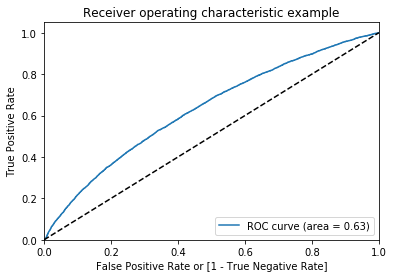

In [43]:
fpr, tpr, thresholds = roc_curve( label_val,val_prob,drop_intermediate = False )

plt.figure(figsize=(6, 4))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % val_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Selecting a subset of best features which have non zero feature importances

In [49]:
feat_imp = pd.Series(data = feat_imp , index=features)
feat_imp = feat_imp.sort_values(ascending=False)
non_zero_imp_feat = list(feat_imp[feat_imp!=0].index)

Plotting the correlation heat map to see if there are any important varaibles which have high correlation

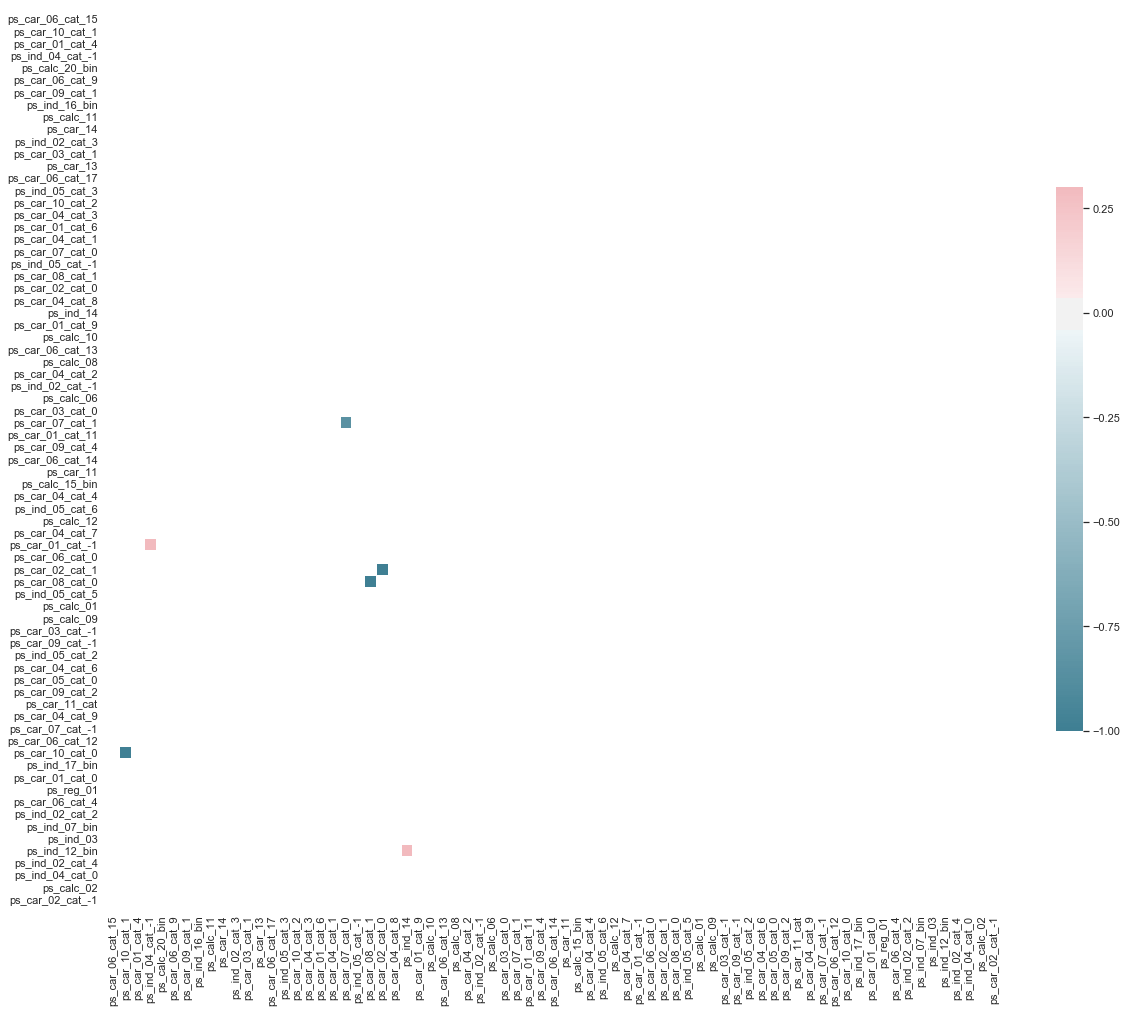

In [45]:
sns.set(style="white")

# Compute the correlation matrix
df_corr = df_trn[non_zero_imp_feat].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr[np.abs(df_corr)>0.8], mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#Not many correlated values

Since the correlated features are not so important, they are left as it is

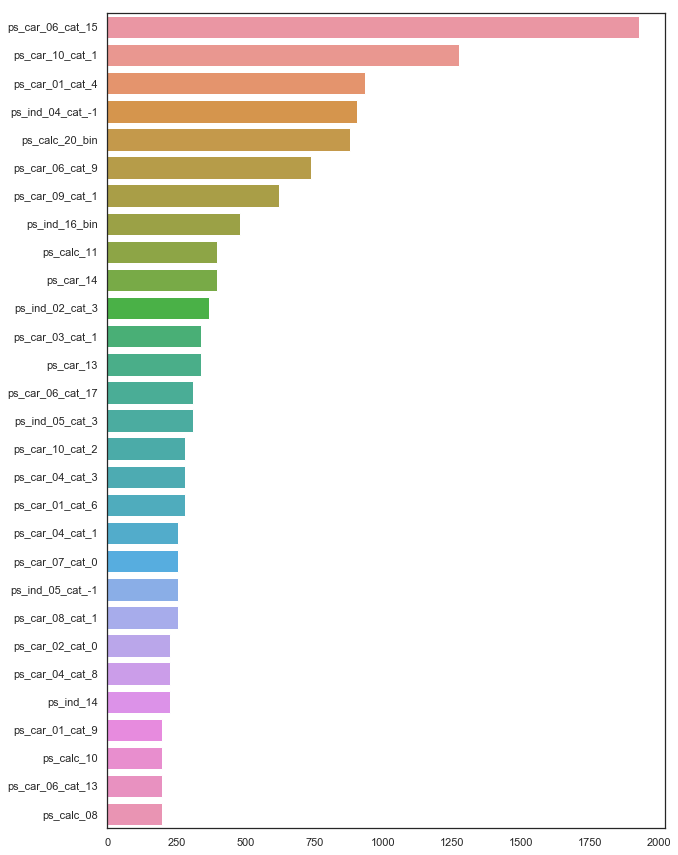

In [52]:
most_imp_feat = (feat_imp[feat_imp>(feat_imp.max()*0.1)])
fig, ax = plt.subplots(figsize=(10,15))
ax = sns.barplot(x=most_imp_feat.values, y=most_imp_feat.index)
#Plotting a barplot of feature importances